# 0.0 Imports

In [186]:
import pandas as pd
import numpy  as np

import re
import random
import pickle
#import requests
import datetime
import inflection

import seaborn   as sns
import umap

from sklearn import preprocessing as pp
from sklearn import cluster as c
from sklearn import metrics as m 

from matplotlib           import pyplot as plt
from IPython.core.display import HTML
from matplotlib.gridspec  import GridSpec

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1 Helper functions

In [6]:
def rename_columns(dataframe):
    df = dataframe.copy()
    title = lambda x: inflection.titleize(x)
    snakecase = lambda x: inflection.underscore(x)
    spaces = lambda x: x.replace(" ", "")
    cols_old = list(df.columns)
    #cols_old = list(map(title, cols_old))
    cols_old = list(map(spaces, cols_old))
    cols_new = list(map(snakecase, cols_old))
    df.columns = cols_new
    return df

def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    #pd.set_option('max_columns', None, "max_rows", 50)
    pd.options.display.max_rows = 999
    pd.set_option( 'display.expand_frame_repr', False )
    pd.options.mode.copy_on_write = True
    
    sns.set()

In [7]:
jupyter_settings()

## 0.2 Loading data

In [8]:
df_raw = pd.read_excel('../data/raw/Online Retail.xlsx')

In [9]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# 1.0 Data description

In [10]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [11]:
# Using the function we created in section 0.1
df1 = rename_columns(df1)

## 1.2 Data dimensions

In [12]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of cols: 8


## 1.3 Data types

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id            float64
country                 object
dtype: object

## 1.4 Check NA

In [14]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA 

In [15]:
# Separando o df com os NA na coluna customer_id
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [21]:
# Arbitrando um id para os todos os customers que estão sem id

# Definindo aleatoriamente para cada invoice unico (drop duplicate)
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

In [23]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change types

In [24]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)

# invoice number
df1['invoice_no'] = df1['invoice_no'].astype(str)

# stock code
df1['stock_code'] = df1['stock_code'].astype(str)

In [25]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

## 1.7. Descriptive Statistics

In [26]:
num_attributes = df1.select_dtypes( include=['int64', 'float64', 'int32'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical attribuites

In [27]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


1. Quantity negativa
2. Unit price zero

### 1.7.2. Categorical Attributes

In [28]:
# problema: Temos invoice com letras e numeros
#df1['invoice_no'].astype( int )

# identficacao: 
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search("[^0-9]+",x))), :]
df_letter_invoices.head()

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 9291
Total number of negative quantity: 9288


Stock code

In [29]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Acão:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

Description

In [30]:
df1.head()

# Acão: Delete description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,17850


Country

In [31]:
df1['country'].value_counts( normalize=True ).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [32]:
df1[['customer_id', 'country']].drop_duplicates().groupby( 'country' ).count().reset_index().sort_values( 'customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0 Feature filtering

In [33]:
df2 = df1.copy()

In [36]:
df2.loc[df2['customer_id']==16446,:]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18 09:52:00,1.65,United Kingdom,16446
194355,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18 09:52:00,1.25,United Kingdom,16446
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,United Kingdom,16446
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,United Kingdom,16446


In [37]:
# === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] )]

# description
df2 = df2.drop( columns='description', axis=1 )

# map 
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# 3.0 Feature engineering

In [128]:
df3 = df2.copy()

## 3.1 Feature creation

In [129]:
cols_drop = ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country']

df_ref = df3.drop(cols_drop, axis=1).drop_duplicates(ignore_index=True)

### 3.1.1 Gross Revenue

In [130]:
# Gross Revenue
df2_purchases['gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']

# Monetary
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency - Days from last purchase

In [131]:
# Recency - Last day purchase
# Calculate how many days has passed from the day that the customer had a purchase
# **inverter função**
df_recency = df2_purchases[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2_purchases['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
#df_recency['recency_days'] = df_recency['recency_days'].apply( lambda x: 1 / x if x != 0 else 0)
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 Quantity of invoices (orders)

In [132]:
# Count of how many invoices the customer have
df_freq = (df2_purchases[['customer_id', 'invoice_no']].drop_duplicates()
                                                       .groupby( 'customer_id' )
                                                       .count()
                                                       .reset_index()
                                                       .rename(columns={'invoice_no':'qtd_invoice'}))
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtd_invoice      91
dtype: int64

### 3.1.4 Quantity of total items bought

In [133]:
# Calculate how many items the customer has bought in total
df_qtd = df2_purchases.loc[:,['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtd_items'})
df_ref = pd.merge( df_ref, df_qtd, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtd_invoice      91
qtd_items        91
dtype: int64

### 3.1.5 Quantity of unique products (stock_code/SKU)

In [134]:
df_stock = df2_purchases.loc[:, ['customer_id', 'stock_code']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'stock_code':'unique_products'})
df_ref = pd.merge( df_ref, df_stock, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id         0
gross_revenue      91
recency_days       91
qtd_invoice        91
qtd_items          91
unique_products    91
dtype: int64

### 3.1.6 Average ticket value

In [135]:
# Avg Ticket
df_avg_ticket = df2_purchases[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')

df_ref.isna().sum()

customer_id         0
gross_revenue      91
recency_days       91
qtd_invoice        91
qtd_items          91
unique_products    91
avg_ticket         91
dtype: int64

### 3.1.7 Average receny days

In [136]:
df_aux = df2_purchases.loc[:,['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[False, False])
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['previous_date'] = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['previous_date'] - x['invoice_date']).days if x['customer_id']==x['next_customer_id'] else np.nan, axis=1)

df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

# Now we have how many days from last purchase, we will get the mean days between orders
df_aux = df_aux.groupby('customer_id').mean().reset_index()

df_ref = pd.merge( df_ref, df_aux, on='customer_id', how='left')

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtd_invoice           91
qtd_items             91
unique_products       91
avg_ticket            91
avg_recency_days    2952
dtype: int64

### 3.1.8 Frequency purchase

In [150]:
df_aux = (df2_purchases.loc[:,['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                                            .groupby('customer_id')
                                                                            .agg(max_ = ('invoice_date','max'),
                                                                                 min_ = ('invoice_date','min'),
                                                                                 days_ = ('invoice_date', lambda x: (x.max()-x.min()).days + 1),
                                                                                 buy_ = ('invoice_no','count')
                                                                                )
                                                                            .reset_index())

# How many purchases per day the customer have
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)

df_aux = df_aux.drop(['max_', 'min_', 'days_', 'buy_'], axis=1)

df_ref = pd.merge(df_ref, df_aux, on='customer_id', how='left')

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtd_invoice           91
qtd_items             91
unique_products       91
avg_ticket            91
avg_recency_days    2952
frequency             91
dtype: int64

### 3.1.9 Total returns

In [159]:
df_aux = df2_returns.loc[:, ['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtd_returns'})
df_aux['qtd_returns'] = df_aux['qtd_returns'] *-1

df_ref = pd.merge( df_ref, df_aux, how='left', on='customer_id' )

# Input zero for customers that not have any returns
df_ref.loc[df_ref['qtd_returns'].isna(), 'qtd_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtd_invoice           91
qtd_items             91
unique_products       91
avg_ticket            91
avg_recency_days    2952
frequency             91
qtd_returns            0
dtype: int64

### 3.1.10 Basket size - Quantity of items per order

In [166]:
df_aux = (df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                         .agg(n_purchase=('invoice_no', 'nunique'), 
                                                                              n_products=('quantity', 'sum'))
                                                                         .reset_index())
# Calculate the average products bought per order
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

df_aux = df_aux.drop(columns=['n_purchase', 'n_products'], axis=1)

df_ref = pd.merge( df_ref, df_aux, how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtd_invoice           91
qtd_items             91
unique_products       91
avg_ticket            91
avg_recency_days    2952
frequency             91
qtd_returns            0
avg_basket_size       91
dtype: int64

### 3.1.11 Unique basket size - Unique items per order

In [168]:
df_aux = (df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                         .agg(n_purchase=('invoice_no', 'nunique'), 
                                                                              n_products=('stock_code', 'nunique'))
                                                                         .reset_index())
# Calculate the average products bought per order
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

df_aux = df_aux.drop(columns=['n_purchase', 'n_products'], axis=1)

df_ref = pd.merge( df_ref, df_aux, how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtd_invoice                 91
qtd_items                   91
unique_products             91
avg_ticket                  91
avg_recency_days          2952
frequency                   91
qtd_returns                  0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# 4.0 EDA - Análise exploratória dos dados

In [170]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtd_invoice               0
qtd_items                 0
unique_products           0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtd_returns               0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

In [171]:
df4.head()

,customer_id,gross_revenue,recency_days,qtd_invoice,qtd_items,unique_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,371.0,34.0,1733.0,21.0,18.152222,0.000000,17.000000,40.0,50.970588,0.617647
1,13047,3232.59,56.0,9.0,1390.0,105.0,18.904035,45.000000,0.028302,35.0,154.444444,11.666667
2,12583,6705.38,2.0,15.0,5028.0,114.0,28.902500,26.000000,0.040431,50.0,335.200000,7.600000
3,13748,948.25,95.0,5.0,439.0,24.0,33.866071,92.333333,0.017921,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,80.0,1.0,292.000000,19.500000,0.073171,22.0,26.666667,0.333333


## 4.1 Análise univariada

### 4.1.1 Response variable

### 4.1.2 Numerical variable

### 4.1.3 Categorical variable

## 4.2 Análise bivariada

### 4.2.x Hipothesis validation

### 4.2.y Hipothesis resume

## 4.3 Análise multivariada

### 4.3.1 Numerical attributes

### 4.3.2 Categorical attributes

# 5.0 Data Preparation

In [172]:
df5 = df4.copy()

## 5.1 Normalization

In [173]:
df5.columns

Index(['customer_id', 'gross_revenue', 'recency_days', 'qtd_invoice',
       'qtd_items', 'unique_products', 'avg_ticket', 'avg_recency_days',
       'frequency', 'qtd_returns', 'avg_basket_size',
       'avg_unique_basket_size'],
      dtype='object')

In [175]:
## Standard Scalaer
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['qtd_invoice'] = ss.fit_transform(df5[['qtd_invoice']])
df5['qtd_items'] = ss.fit_transform(df5[['qtd_items']])
df5['unique_products'] = ss.fit_transform(df5[['unique_products']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])
df5['avg_recency_days'] = ss.fit_transform(df5[['avg_recency_days']])
df5['frequency'] = ss.fit_transform(df5[['frequency']])
df5['qtd_returns'] = ss.fit_transform(df5[['qtd_returns']])
df5['avg_basket_size'] = ss.fit_transform(df5[['avg_basket_size']])
df5['avg_unique_basket_size'] = ss.fit_transform(df5[['avg_unique_basket_size']])

In [176]:
df5.head()

,customer_id,gross_revenue,recency_days,qtd_invoice,qtd_items,unique_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size
0,17850,0.247091,4.382245,3.117134,0.014857,-0.629444,-0.068966,-1.107300,35.940873,0.019866,-0.642534,-0.973552
1,13047,0.039287,-0.033801,0.337482,-0.043974,0.225951,-0.066204,-0.418715,-0.148528,0.002479,-0.278228,-0.344075
2,12583,0.373602,-0.790838,1.004598,0.580017,0.317600,-0.029481,-0.709451,-0.122736,0.054642,0.358167,-0.575758
3,13748,-0.180620,0.512947,-0.107263,-0.207090,-0.598894,-0.011250,0.305574,-0.170602,-0.119235,-0.512867,-0.735278
4,15100,-0.187575,3.849515,-0.329635,-0.268666,-0.833109,0.936848,-0.808913,-0.053117,-0.042729,-0.728102,-0.989750


# 6.0 Feature selection

In [177]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tunning

In [178]:
X = df6.drop( columns=['customer_id'] )

In [179]:
X.head()

,gross_revenue,recency_days,qtd_invoice,qtd_items,unique_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size
0,0.247091,4.382245,3.117134,0.014857,-0.629444,-0.068966,-1.107300,35.940873,0.019866,-0.642534,-0.973552
1,0.039287,-0.033801,0.337482,-0.043974,0.225951,-0.066204,-0.418715,-0.148528,0.002479,-0.278228,-0.344075
2,0.373602,-0.790838,1.004598,0.580017,0.317600,-0.029481,-0.709451,-0.122736,0.054642,0.358167,-0.575758
3,-0.180620,0.512947,-0.107263,-0.207090,-0.598894,-0.011250,0.305574,-0.170602,-0.119235,-0.512867,-0.735278
4,-0.187575,3.849515,-0.329635,-0.268666,-0.833109,0.936848,-0.808913,-0.053117,-0.042729,-0.728102,-0.989750


In [180]:
clusters = np.arange(2, 10, 1)

## 7.1 Within-Cluster Sum of Square (WSS)

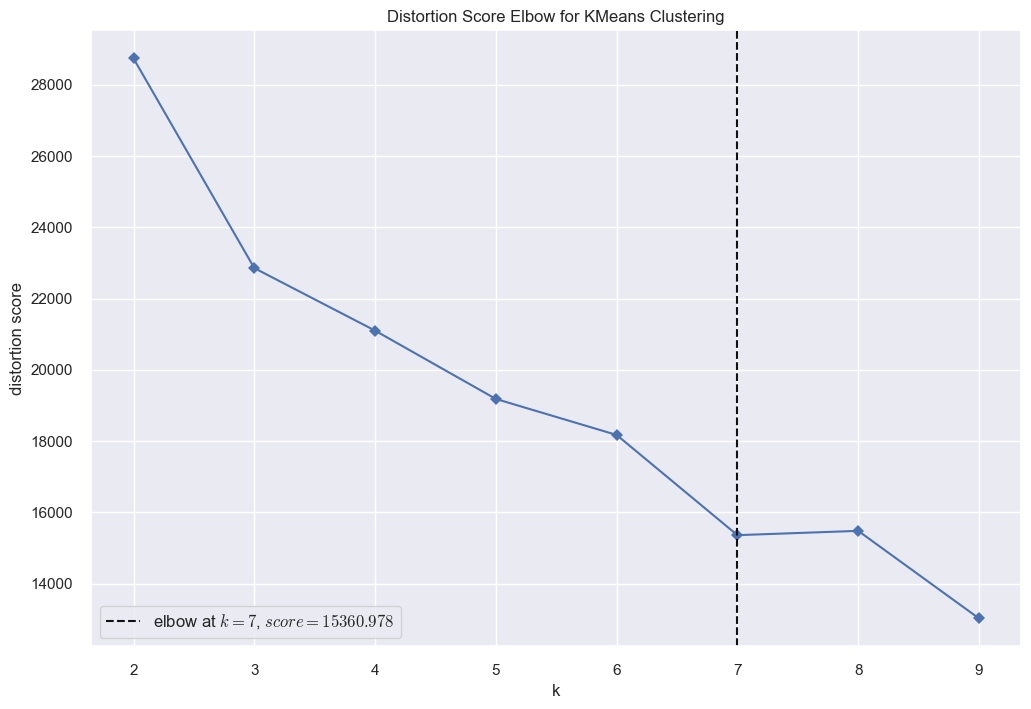

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [181]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show()

## 7.2 Silhouette Score

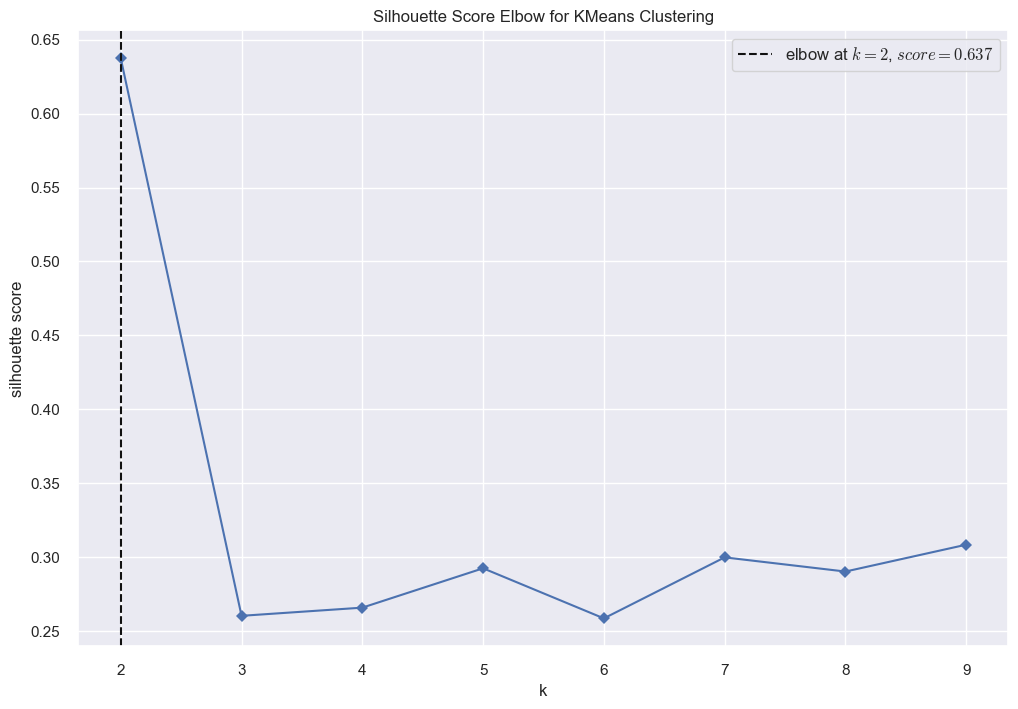

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [182]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show()

## 7.3 Silhouette Analysis

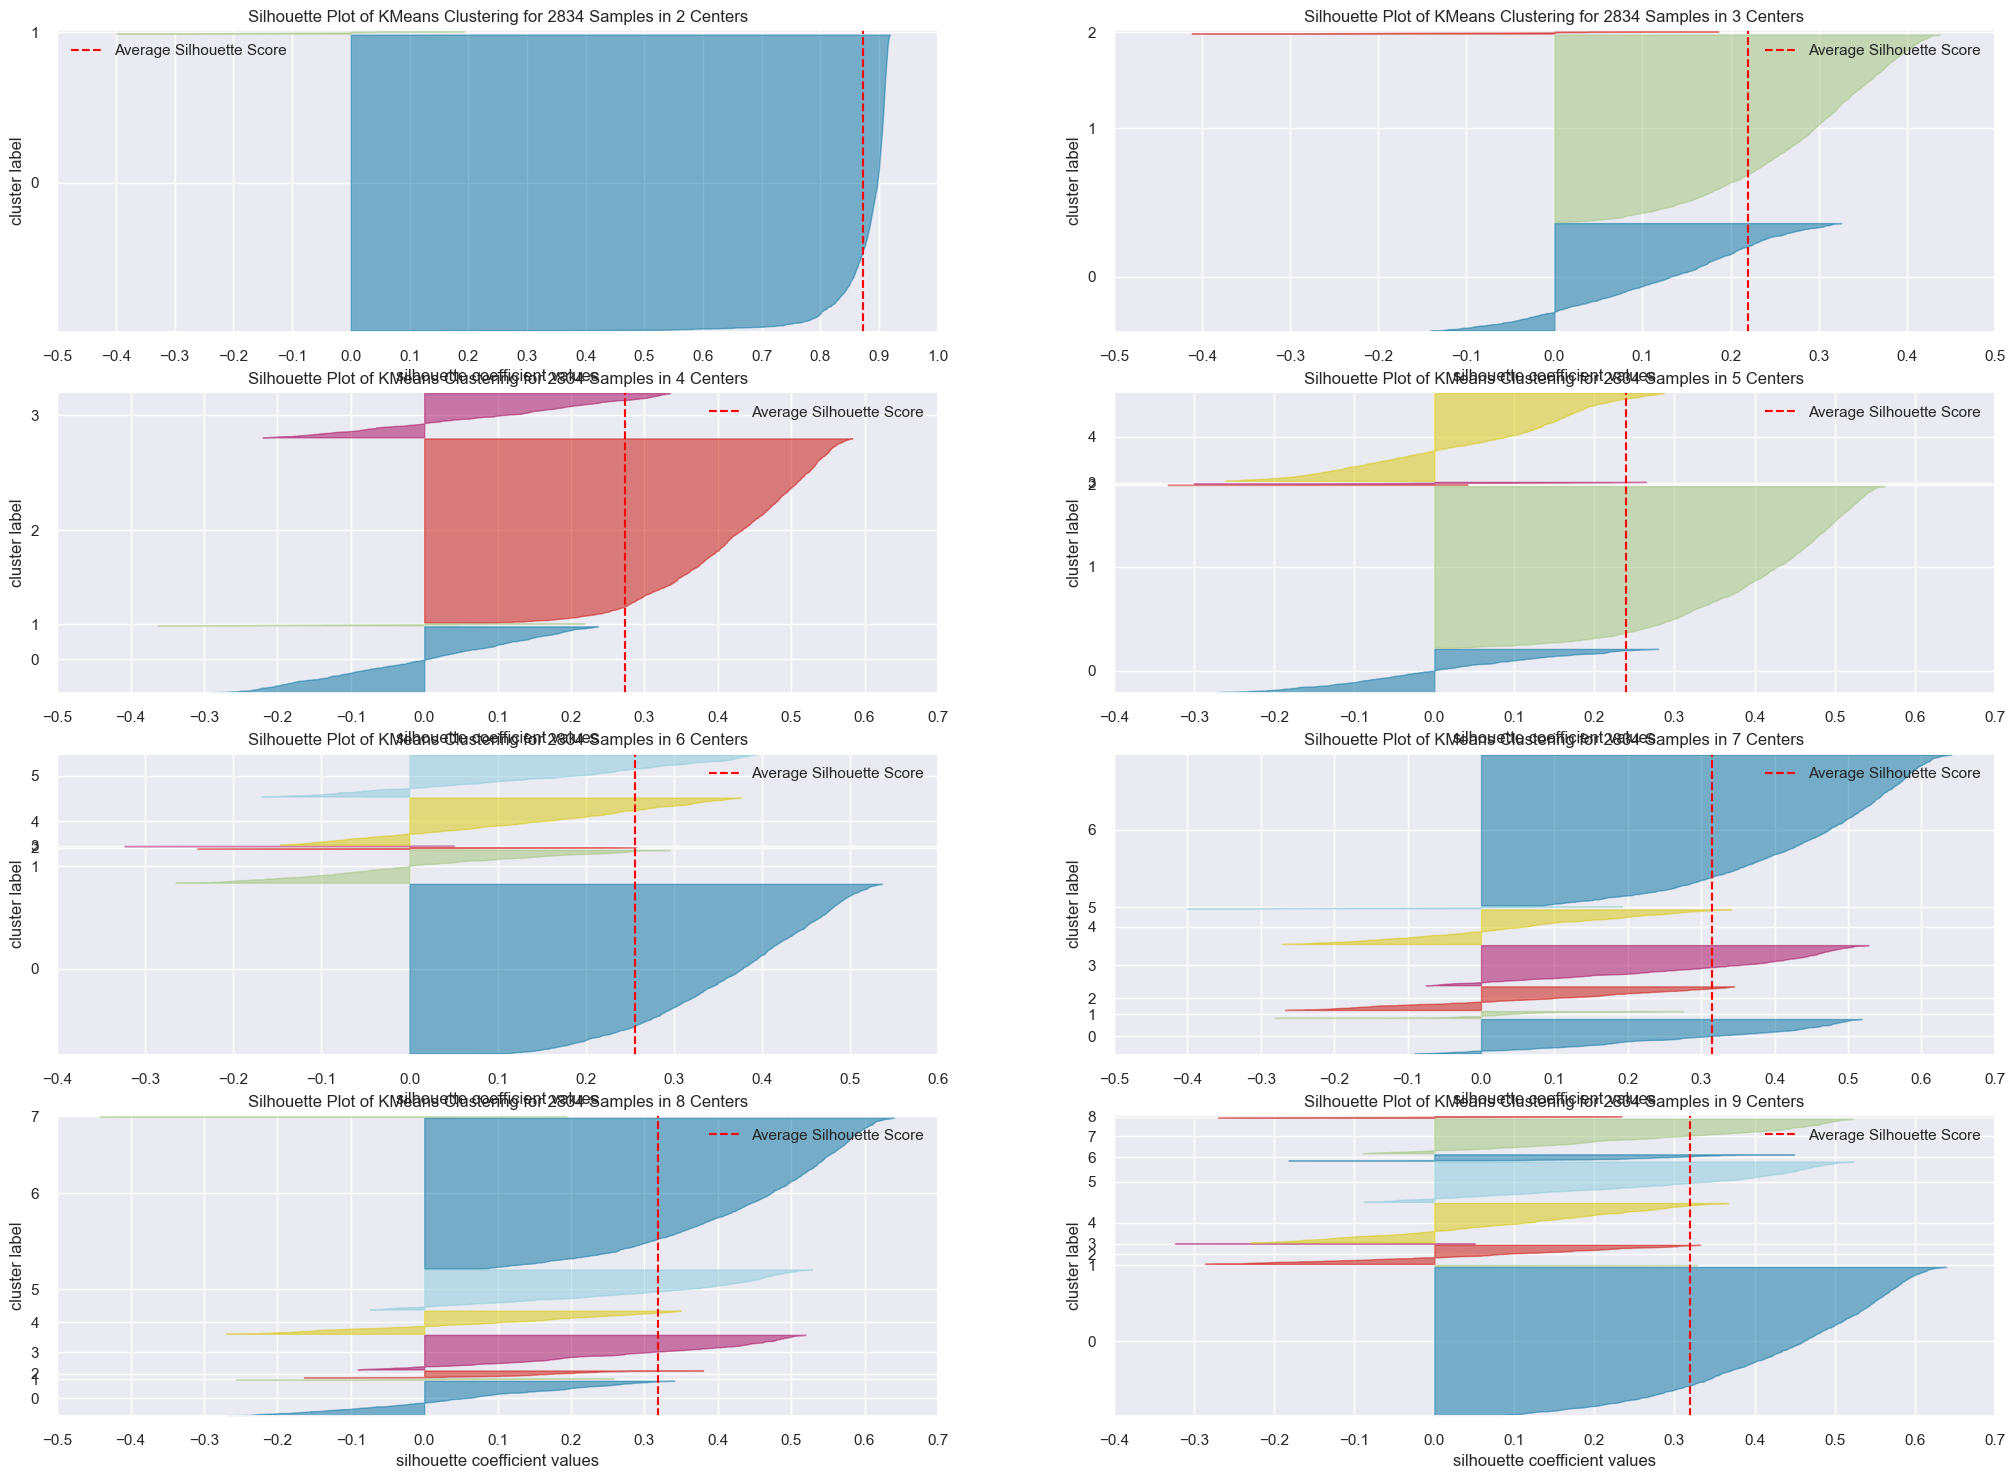

In [183]:
fig, ax = plt.subplots( 4, 2, figsize=(25, 18) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

# 8.0 Model training

## 8.1 K-Means

In [191]:
# Model definition
k = 3 
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, random_state=42, max_iter=300 )

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

### 8.1.1 Cluster validation

In [192]:
## WSS ( Within-cluster sum of square)
print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 22851.30738134662
SS value: 0.2196160265751297


# 9.0 Cluster analysis

In [193]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,qtd_invoice,qtd_items,unique_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size,cluster
0,17850,0.247091,4.382245,3.117134,0.014857,-0.629444,-0.068966,-1.107300,35.940873,0.019866,-0.642534,-0.973552,0
1,13047,0.039287,-0.033801,0.337482,-0.043974,0.225951,-0.066204,-0.418715,-0.148528,0.002479,-0.278228,-0.344075,1
2,12583,0.373602,-0.790838,1.004598,0.580017,0.317600,-0.029481,-0.709451,-0.122736,0.054642,0.358167,-0.575758,1
3,13748,-0.180620,0.512947,-0.107263,-0.207090,-0.598894,-0.011250,0.305574,-0.170602,-0.119235,-0.512867,-0.735278,0
4,15100,-0.187575,3.849515,-0.329635,-0.268666,-0.833109,0.936848,-0.808913,-0.053117,-0.042729,-0.728102,-0.989750,0


c:\Users\Gabriel\anaconda3\envs\customer_identification\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


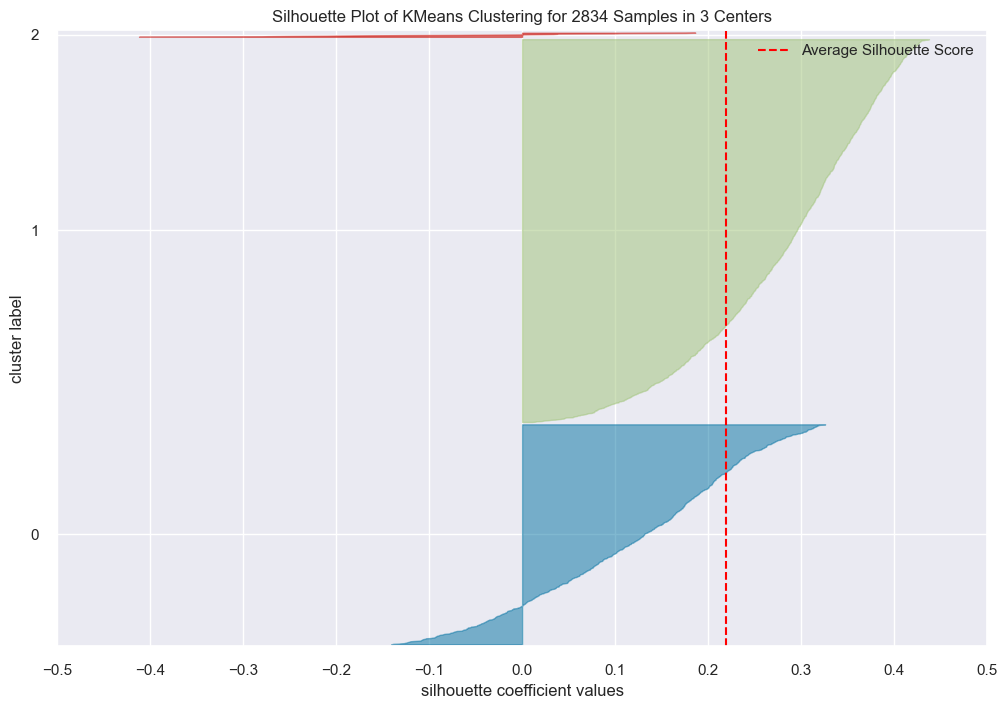

In [194]:
visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
visualizer.fit( X )
visualizer.finalize()

## 9.2. 2d plot

In [195]:
df_viz = df9.drop( columns='customer_id', axis=1 )
#sns.pairplot( df_viz, hue='cluster' )

## 9.3. UMAP

c:\Users\Gabriel\anaconda3\envs\customer_identification\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

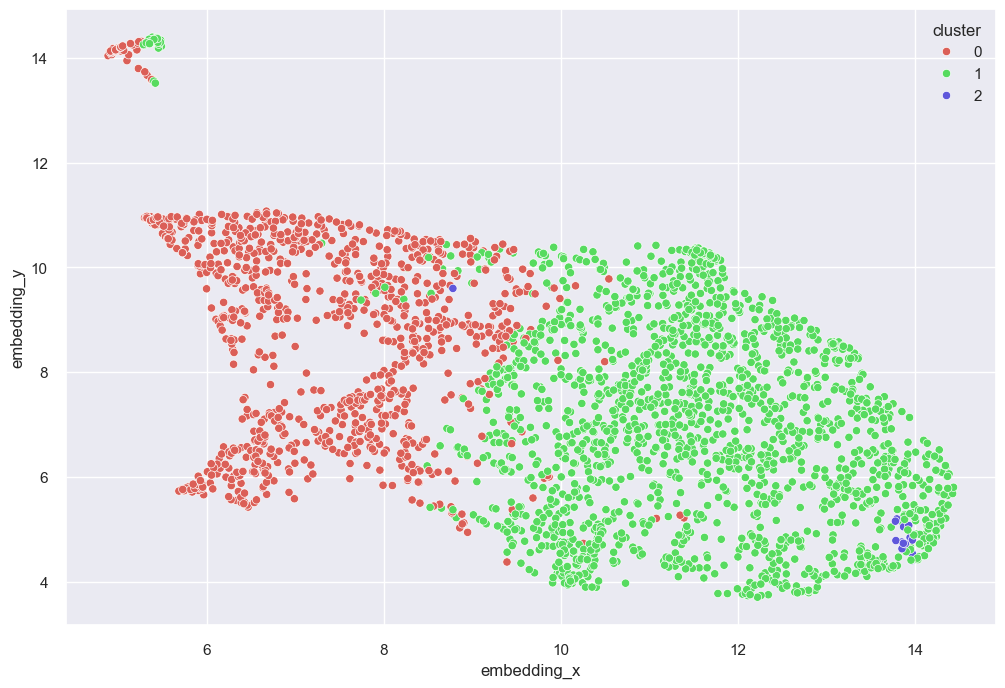

In [196]:
reducer = umap.UMAP( n_neighbors=90, random_state=41 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz )

## 9.2 Cluster profile

In [114]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='cluster' )

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,3043,70.277136,-0.077530,-0.488171,-0.079286,-0.026487
1,1,208,4.803695,1.112384,-0.785403,2.339905,0.047978
2,2,1065,24.595843,-0.173472,1.556433,-0.354004,-0.019614
3,3,12,0.277136,13.519256,-0.845419,11.025006,0.070872
4,4,2,0.046189,13.532067,0.706686,-0.359589,45.329979


# 10.0 Deploy